In [1]:
from multiprocessing import Pool, cpu_count
import itertools

In [2]:
from joblib import Parallel, delayed
from tqdm import tqdm
import joblib
import contextlib
import os

In [3]:
# =========================================================
# 1. SETUP
# =========================================================

import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import linprog
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
from hybrid_tuned_with_das_combined import (run_nsga,hybrid_with_tuning,compute_fcm_das_scores,greedy_refine,lp_refine)

RANDOM_SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(RANDOM_SEED)

In [4]:
# =========================================================
# 2. LOAD DATA
# =========================================================

CSV_PATH = "final_exporter_profiles.csv"
df_master = pd.read_csv(CSV_PATH)

print("Suppliers:", len(df_master))

Suppliers: 40


In [5]:
# =========================================================
# 3. SCENARIO GRID (625 scenarios)
# =========================================================

volumes = [50000, 100000, 200000, 300000, 400000]
risk_weights = [0.0, 0.25, 0.5, 0.75, 1.0]
max_shares = [0.3, 0.4, 0.5, 0.6, 0.7]
min_suppliers_list = [3, 5, 7, 9, 11]

scenarios = list(product(volumes, risk_weights, max_shares, min_suppliers_list))
print("Total scenarios:", len(scenarios))

Total scenarios: 625


In [6]:
# =========================================================
# 4. RAW IMPROVEMENT METRICS
# =========================================================

def compute_metrics(df, allocation):
    cost = np.dot(df['avg_cost_per_tonne'], allocation) / allocation.sum()
    em = np.dot(df['avg_emissions_kpi'], allocation) / allocation.sum()
    de = np.dot(df['avg_deforestation_kpi'], allocation) / allocation.sum()
    return cost, em, de


def compute_improvements(df, allocation):
    baseline_alloc = df['total_volume'].values
    
    base_cost, base_em, base_def = compute_metrics(df, baseline_alloc)
    opt_cost, opt_em, opt_def = compute_metrics(df, allocation)
    
    cost_imp = (base_cost - opt_cost) / (base_cost + 1e-9)
    em_imp = (base_em - opt_em) / (base_em + 1e-9)
    def_imp = (base_def - opt_def) / (base_def + 1e-9)
    
    return cost_imp, em_imp, def_imp

In [69]:
# =========================================================
# ENTROPY WEIGHT MATRIX
# =========================================================
def compute_entropy_weights_matrix(X):
    P = X / (X.sum(axis=0) + 1e-9)
    E = -np.nansum(P * np.log(P + 1e-9), axis=0) / np.log(len(X))
    d = 1 - E
    w = d / (d.sum() + 1e-9)
    return w

In [8]:
def model_cost_only(df, volume, max_share):
    cost = df['avg_cost_per_tonne'].values
    sorted_idx = np.argsort(cost)
    ub = np.minimum(max_share * volume, df['total_volume'].values)

    alloc = np.zeros(len(df))
    remaining = volume
    
    for i in sorted_idx:
        give = min(ub[i], remaining)
        alloc[i] = give
        remaining -= give
        if remaining <= 0:
            break

    return alloc

In [9]:
def model_static_entropy(df, volume, max_share):
    X = df[['avg_emissions_kpi','avg_deforestation_kpi']].values
    col_sum = X.sum(axis=0) + 1e-9
    P = X / col_sum
    E = -np.nansum(P * np.log(P + 1e-9), axis=0) / np.log(len(X))
    d = 1 - E
    w = d / (d.sum() + 1e-9)

    score = w[0]*X[:,0] + w[1]*X[:,1]
    sorted_idx = np.argsort(score)

    ub = np.minimum(max_share * volume, df['total_volume'].values)
    alloc = np.zeros(len(df))
    remaining = volume
    
    for i in sorted_idx:
        give = min(ub[i], remaining)
        alloc[i] = give
        remaining -= give
        if remaining <= 0:
            break

    return alloc

In [10]:
def model_fcm_only(df, volume, max_share, risk_weight):
    scored, _ = compute_fcm_das_scores(df.copy(), {}, risk_weight)
    scores = scored['final_score'].values
    
    sorted_idx = np.argsort(-scores)
    ub = np.minimum(max_share * volume, df['total_volume'].values)

    alloc = np.zeros(len(df))
    remaining = volume
    
    for i in sorted_idx:
        give = min(ub[i], remaining)
        alloc[i] = give
        remaining -= give
        if remaining <= 0:
            break

    return alloc

In [11]:
def model_nsga_only(df, volume, max_share):
    # Use real NSGA with neutral sustainability
    df_temp = df.copy()
    df_temp['final_score'] = 1.0  # neutral sustainability

    result = run_nsga(
        df_temp,
        required_volume=volume,
        max_share=max_share,
        pop_size=60,
        gens=80,
        sbx_eta=15,
        pm_eta=15,
        crossover_prob=0.9
    )

    F = result.F

    # Entropy-based Pareto ranking
    weights = compute_entropy_weights_matrix(F)
    scores = F @ weights

    best_index = np.argmin(scores)

    alloc = result.X[best_index]
    alloc = alloc / (alloc.sum() + 1e-9) * volume
    return alloc

In [12]:
def model_full_hybrid(volume, risk_weight, max_share, min_suppliers):
    result = hybrid_with_tuning(
        CSV_PATH,
        required_volume=volume,
        max_share_per_supplier=max_share,
        min_suppliers=min_suppliers,
        user_risk_weight=risk_weight,
        das_enabled=True,
        random_seed=42
    )
    return result["allocation_vector"]

In [13]:
def model_fcm_nsga(df, volume, max_share, risk_weight):
    scored, _ = compute_fcm_das_scores(df.copy(), {}, risk_weight)

    result = run_nsga(
        scored,
        required_volume=volume,
        max_share=max_share,
        pop_size=60,
        gens=80,
        sbx_eta=15,
        pm_eta=15,
        crossover_prob=0.9
    )

    F = result.F
    weights = compute_entropy_weights_matrix(F)
    scores = F @ weights

    best_index = np.argmin(scores)

    alloc = result.X[best_index]
    alloc = alloc / (alloc.sum() + 1e-9) * volume
    return alloc

In [14]:
def run_single_scenario(params):
    volume, risk_weight, max_share, min_supplier = params

    # Reproducibility
    set_seed(42)

    df = df_master.copy()

    models = {
        "Cost_Only": model_cost_only(df, volume, max_share),
        "Static_Entropy": model_static_entropy(df, volume, max_share),
        "FCM_Only": model_fcm_only(df, volume, max_share, risk_weight),
        "NSGA_Only": model_nsga_only(df, volume, max_share),
        "FCM_NSGA": model_fcm_nsga(df, volume, max_share, risk_weight),
        "Full_Hybrid": hybrid_with_tuning(
            CSV_PATH,
            required_volume=volume,
            max_share_per_supplier=max_share,
            min_suppliers=min_supplier,
            user_risk_weight=risk_weight,
            fcm_param_grid=None,
            nsga_param_grid=None,
            das_enabled=True,
            random_seed=42
        )["allocation_vector"]
    }

    scenario_results = []

    for model_name, alloc in models.items():
        cost_imp, em_imp, def_imp = compute_improvements(df, alloc)

        scenario_results.append({
            "Volume": volume,
            "Risk_Weight": risk_weight,
            "Max_Share": max_share,
            "Min_Supplier": min_supplier,
            "Model": model_name,
            "Cost_Imp": cost_imp,
            "Emission_Imp": em_imp,
            "Deforestation_Imp": def_imp
        })

    return scenario_results

In [15]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [16]:
print(f"Total scenarios: {len(scenarios)}")
print(f"Using {os.cpu_count()} CPU cores")

with tqdm_joblib(tqdm(total=len(scenarios))) as progress_bar:
    results_nested = Parallel(n_jobs=-1, backend="loky")(
        delayed(run_single_scenario)(params)
        for params in scenarios
    )

# Flatten results
results = [item for sublist in results_nested for item in sublist]

results_df = pd.DataFrame(results)

Total scenarios: 625
Using 16 CPU cores


100%|██████████| 625/625 [48:50<00:00,  4.69s/it]  


In [70]:


# Compute entropy weights across ALL scenario results
improvement_matrix = results_df[['Cost_Imp','Emission_Imp','Deforestation_Imp']].values
weights = compute_entropy_weights_matrix(improvement_matrix)

results_df["CII"] = (
    weights[0]*results_df["Cost_Imp"] +
    weights[1]*results_df["Emission_Imp"] +
    weights[2]*results_df["Deforestation_Imp"]
)

# Environmental-only entropy
env_matrix = results_df[['Emission_Imp','Deforestation_Imp']].values
env_weights = compute_entropy_weights_matrix(env_matrix)

results_df["NSG"] = (
    env_weights[0]*results_df["Emission_Imp"] +
    env_weights[1]*results_df["Deforestation_Imp"]
)

results_df.to_csv("strict_7_model_results_final.csv", index=False)
print("Entropy aggregation complete.")

Entropy aggregation complete.


C:\Users\karti\AppData\Local\Temp\ipykernel_29124\351251655.py:6: RuntimeWarning: invalid value encountered in log
  E = -np.nansum(P * np.log(P + 1e-9), axis=0) / np.log(len(X))
C:\Users\karti\AppData\Local\Temp\ipykernel_29124\351251655.py:6: RuntimeWarning: invalid value encountered in log
  E = -np.nansum(P * np.log(P + 1e-9), axis=0) / np.log(len(X))


In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# -----------------------------
# Load Existing Results
# -----------------------------

results_df = pd.read_csv("strict_7_model_results_final.csv")
df_full = pd.read_csv("final_exporter_profiles.csv")

# Remove old TOPSIS rows if present
results_df = results_df[results_df["Model"] != "TOPSIS"]

# -----------------------------
# Metric Function
# -----------------------------

def compute_metrics(df, alloc):
    cost = np.dot(df["avg_cost_per_tonne"], alloc) / alloc.sum()
    em = np.dot(df["avg_emissions_kpi"], alloc) / alloc.sum()
    de = np.dot(df["avg_deforestation_kpi"], alloc) / alloc.sum()
    return cost, em, de

baseline_alloc = df_full["total_volume"].values
baseline_cost, baseline_em, baseline_def = compute_metrics(df_full, baseline_alloc)

# -----------------------------
# Weighted TOPSIS Allocation
# -----------------------------

def weighted_topsis_allocation(df, required_volume, max_share, risk_weight):

    df2 = df.copy().reset_index(drop=True)

    criteria = [
        "avg_cost_per_tonne",
        "avg_emissions_kpi",
        "avg_deforestation_kpi"
    ]

    X = df2[criteria].values.astype(float)

    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)

    # Convert cost-type to benefit
    X_norm = 1 - X_norm

    # Dynamic hierarchical weights
    w_cost = 1 - risk_weight
    w_env = risk_weight / 2

    weights = np.array([w_cost, w_env, w_env])
    weights = weights / weights.sum()

    X_weighted = X_norm * weights

    ideal_best = X_weighted.max(axis=0)
    ideal_worst = X_weighted.min(axis=0)

    dist_best = np.linalg.norm(X_weighted - ideal_best, axis=1)
    dist_worst = np.linalg.norm(X_weighted - ideal_worst, axis=1)

    closeness = dist_worst / (dist_best + dist_worst + 1e-9)

    sorted_idx = np.argsort(-closeness)

    ub = np.minimum(max_share * required_volume, df2["total_volume"].values)

    alloc = np.zeros(len(df2))
    remaining = required_volume

    for i in sorted_idx:
        give = min(ub[i], remaining)
        alloc[i] = give
        remaining -= give
        if remaining <= 0:
            break

    return alloc

# -----------------------------
# Run Weighted TOPSIS for All Scenarios
# -----------------------------

topsis_rows = []

for key, group in results_df.groupby(
    ["Volume","Risk_Weight","Max_Share","Min_Supplier"]
):

    volume, risk, max_share, min_sup = key

    alloc = weighted_topsis_allocation(df_full, volume, max_share, risk)

    cost, em, de = compute_metrics(df_full, alloc)

    cost_imp = (baseline_cost - cost) / (baseline_cost + 1e-9)
    em_imp = (baseline_em - em) / (baseline_em + 1e-9)
    def_imp = (baseline_def - de) / (baseline_def + 1e-9)

    topsis_rows.append({
        "Volume": volume,
        "Risk_Weight": risk,
        "Max_Share": max_share,
        "Min_Supplier": min_sup,
        "Model": "TOPSIS",
        "Cost_Imp": cost_imp,
        "Emission_Imp": em_imp,
        "Deforestation_Imp": def_imp
    })

topsis_df = pd.DataFrame(topsis_rows)

# -----------------------------
# Append & Save Final Results
# -----------------------------

results_df = pd.concat([results_df, topsis_df], ignore_index=True)

results_df.to_csv("strict_7_model_results_final.csv", index=False)

print("✅ Weighted TOPSIS added successfully.")
print("📁 New file saved as: strict_7_model_results_final.csv")

✅ Weighted TOPSIS added successfully.
📁 New file saved as: strict_7_model_results_final.csv


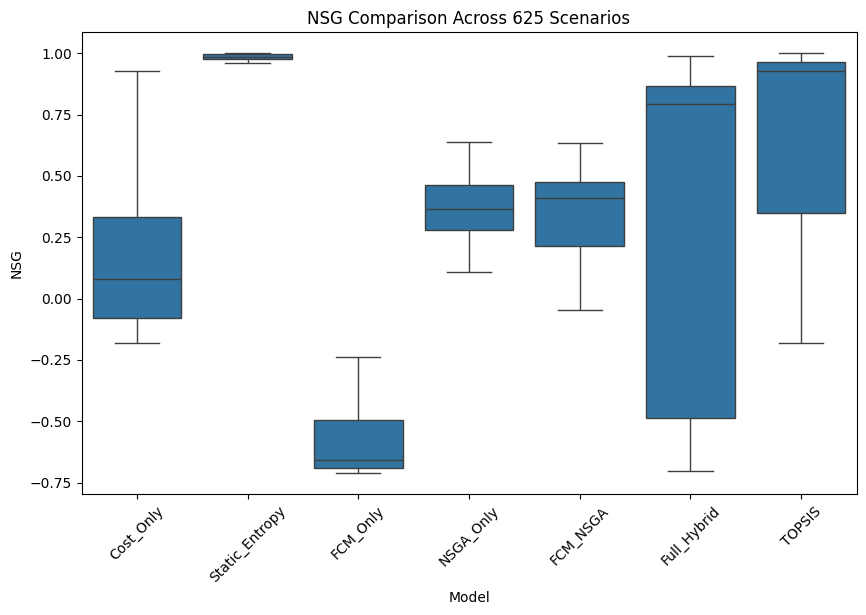

In [71]:
plt.figure(figsize=(10,6))
sns.boxplot(data=results_df, x="Model", y="NSG")
plt.xticks(rotation=45)
plt.title("NSG Comparison Across 625 Scenarios")
plt.show()

In [64]:
results_df = pd.read_csv("strict_7_model_results_final.csv")

In [72]:
import pandas as pd
import numpy as np

# Aggregate metrics
summary = results_df.groupby("Model").agg(
    Mean_Cost_Imp=("Cost_Imp","mean"),
    Mean_Emission_Imp=("Emission_Imp","mean"),
    Mean_Deforestation_Imp=("Deforestation_Imp","mean"),
    Mean_NSG=("NSG","mean"),
    Std_NSG=("NSG","std"),
    Mean_CII=("CII","mean")
).sort_values("Mean_NSG", ascending=False)

summary

,Mean_Cost_Imp,Mean_Emission_Imp,Mean_Deforestation_Imp,Mean_NSG,Std_NSG,Mean_CII
Model,,,,,,
Static_Entropy,0.027333,0.940424,0.991771,0.983573,0.012278,1.095231
TOPSIS,0.131040,0.637552,0.707646,0.696456,0.378957,0.762477
NSGA_Only,0.053770,0.100435,0.408709,0.359493,0.132622,0.395191
FCM_NSGA,0.012620,0.103910,0.396222,0.349555,0.167955,0.388897
Full_Hybrid,0.048942,0.321215,0.316786,0.317493,0.686220,0.348851
Cost_Only,0.180977,0.247926,0.207153,0.213662,0.384445,0.217479
FCM_Only,0.036510,-0.229177,-0.624601,-0.561471,0.154517,-0.631296


In [73]:
rank_table = summary.rank(ascending=False)
rank_table

,Mean_Cost_Imp,Mean_Emission_Imp,Mean_Deforestation_Imp,Mean_NSG,Std_NSG,Mean_CII
Model,,,,,,
Static_Entropy,6.0,1.0,1.0,1.0,7.0,1.0
TOPSIS,2.0,2.0,2.0,2.0,3.0,2.0
NSGA_Only,3.0,6.0,3.0,3.0,6.0,3.0
FCM_NSGA,7.0,5.0,4.0,4.0,4.0,4.0
Full_Hybrid,4.0,3.0,5.0,5.0,1.0,5.0
Cost_Only,1.0,4.0,6.0,6.0,2.0,6.0
FCM_Only,5.0,7.0,7.0,7.0,5.0,7.0


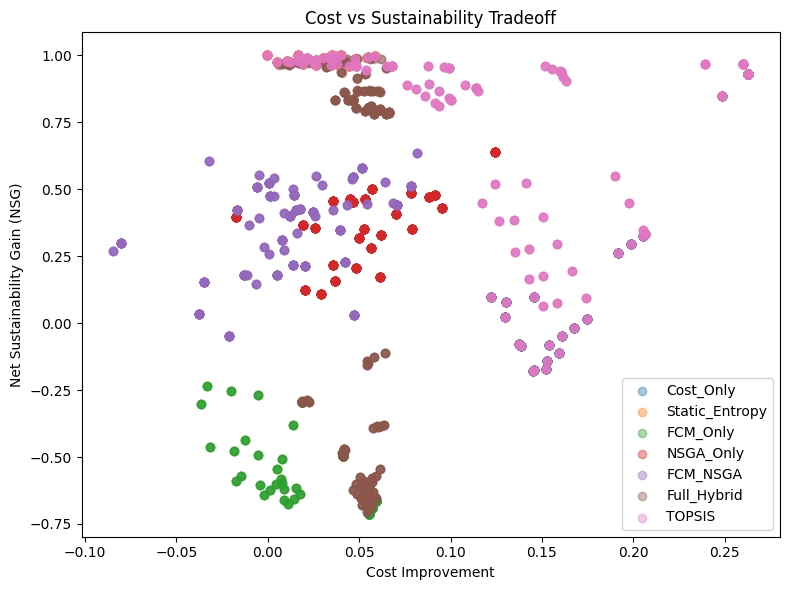

In [74]:
plt.figure(figsize=(8,6))

for model in results_df["Model"].unique():
    subset = results_df[results_df["Model"]==model]
    plt.scatter(subset["Cost_Imp"], subset["NSG"], alpha=0.4, label=model)

plt.xlabel("Cost Improvement")
plt.ylabel("Net Sustainability Gain (NSG)")
plt.legend()
plt.title("Cost vs Sustainability Tradeoff")
plt.tight_layout()
plt.show()

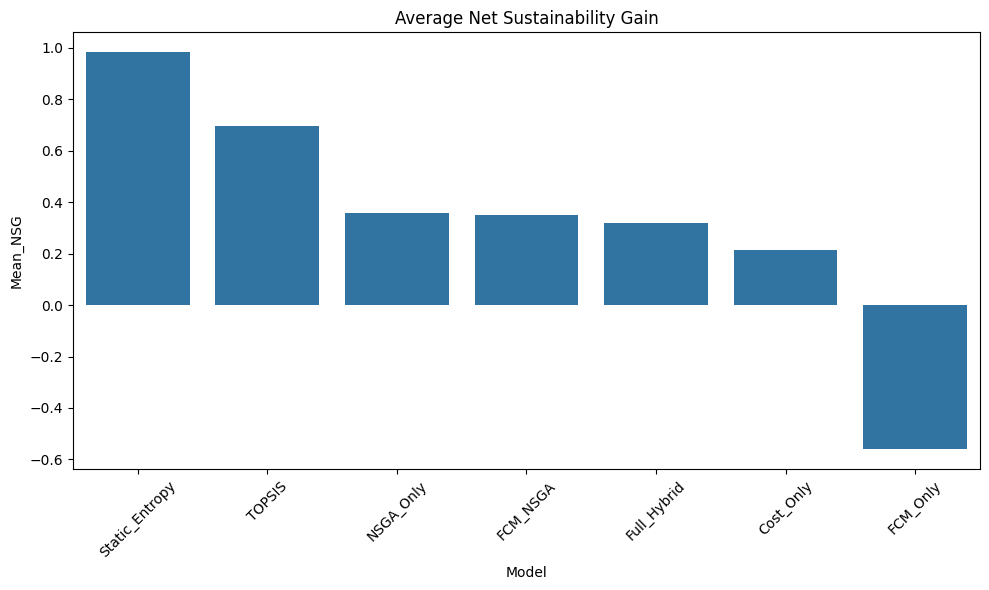

In [75]:
plt.figure(figsize=(10,6))
sns.barplot(data=summary.reset_index(), x="Model", y="Mean_NSG")
plt.xticks(rotation=45)
plt.title("Average Net Sustainability Gain")
plt.tight_layout()
plt.show()

In [76]:
results_df.groupby("Model")[["Cost_Imp","Emission_Imp","Deforestation_Imp"]].mean()

,Cost_Imp,Emission_Imp,Deforestation_Imp
Model,,,
Cost_Only,0.180977,0.247926,0.207153
FCM_NSGA,0.012620,0.103910,0.396222
FCM_Only,0.036510,-0.229177,-0.624601
Full_Hybrid,0.048942,0.321215,0.316786
NSGA_Only,0.053770,0.100435,0.408709
Static_Entropy,0.027333,0.940424,0.991771
TOPSIS,0.131040,0.637552,0.707646


In [77]:
results_df = pd.read_csv("strict_7_model_results_final.csv")

In [78]:
low_risk = results_df[results_df["Risk_Weight"] <= 0.25]
high_risk = results_df[results_df["Risk_Weight"] >= 0.75]

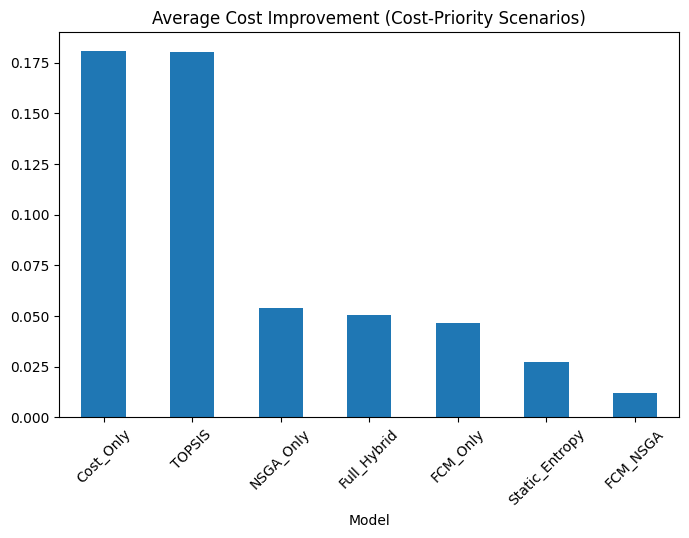

Model
Cost_Only         0.180977
TOPSIS            0.180071
NSGA_Only         0.053770
Full_Hybrid       0.050634
FCM_Only          0.046390
Static_Entropy    0.027333
FCM_NSGA          0.012013
Name: Cost_Imp, dtype: float64

In [79]:
plt.figure(figsize=(8,5))
low_summary = low_risk.groupby("Model")["Cost_Imp"].mean().sort_values(ascending=False)
low_summary.plot(kind="bar")
plt.title("Average Cost Improvement (Cost-Priority Scenarios)")
plt.xticks(rotation=45)
plt.show()

low_summary

C:\Users\karti\AppData\Local\Temp\ipykernel_29124\690010707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_risk["Env_Total"] = (


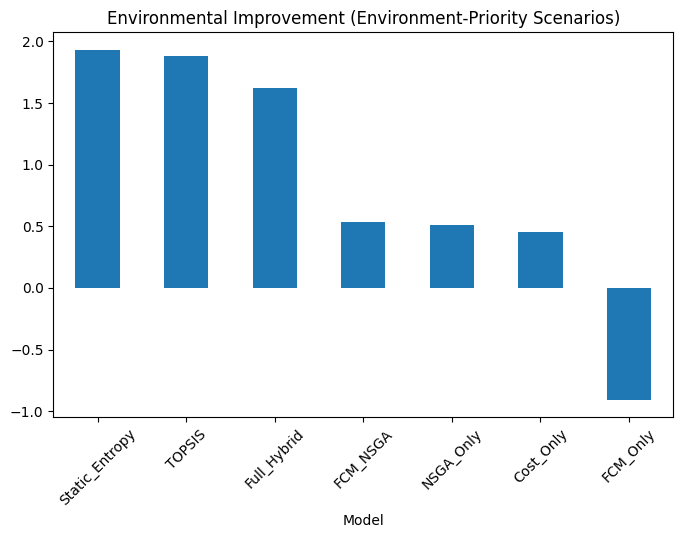

Model
Static_Entropy    1.932195
TOPSIS            1.883244
Full_Hybrid       1.620759
FCM_NSGA          0.532937
NSGA_Only         0.509144
Cost_Only         0.455079
FCM_Only         -0.908144
Name: Env_Total, dtype: float64

In [80]:
high_risk["Env_Total"] = (
    high_risk["Emission_Imp"] +
    high_risk["Deforestation_Imp"]
)

plt.figure(figsize=(8,5))
high_summary = high_risk.groupby("Model")["Env_Total"].mean().sort_values(ascending=False)
high_summary.plot(kind="bar")
plt.title("Environmental Improvement (Environment-Priority Scenarios)")
plt.xticks(rotation=45)
plt.show()

high_summary

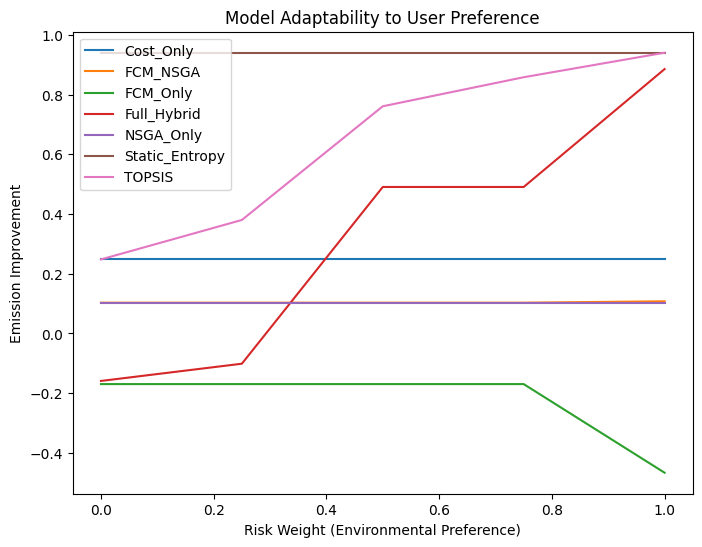

In [81]:
adapt = results_df.groupby(["Risk_Weight","Model"])[
    ["Cost_Imp","Emission_Imp"]
].mean().reset_index()

plt.figure(figsize=(8,6))

for model in adapt["Model"].unique():
    subset = adapt[adapt["Model"] == model]
    plt.plot(subset["Risk_Weight"], subset["Emission_Imp"], label=model)

plt.xlabel("Risk Weight (Environmental Preference)")
plt.ylabel("Emission Improvement")
plt.title("Model Adaptability to User Preference")
plt.legend()
plt.show()

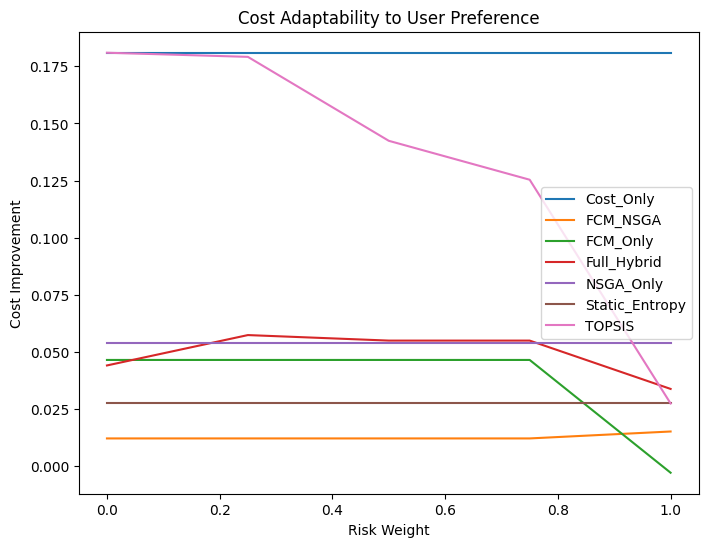

In [82]:
plt.figure(figsize=(8,6))

for model in adapt["Model"].unique():
    subset = adapt[adapt["Model"] == model]
    plt.plot(subset["Risk_Weight"], subset["Cost_Imp"], label=model)

plt.xlabel("Risk Weight")
plt.ylabel("Cost Improvement")
plt.title("Cost Adaptability to User Preference")
plt.legend()
plt.show()

In [83]:
import numpy as np

prs_scores = {}

for model, group in results_df.groupby("Model"):
    
    corr_em = np.corrcoef(group["Risk_Weight"], group["Emission_Imp"])[0,1]
    corr_cost = np.corrcoef(group["Risk_Weight"], group["Cost_Imp"])[0,1]
    
    prs = corr_em - corr_cost  # because cost should decrease
    
    prs_scores[model] = prs

prs_scores = pd.Series(prs_scores).sort_values(ascending=False)
prs_scores

TOPSIS            1.486031e+00
Full_Hybrid       1.184825e+00
Static_Entropy    9.467072e-17
NSGA_Only         9.288787e-18
Cost_Only        -1.257760e-16
FCM_Only         -7.260496e-03
FCM_NSGA         -1.602421e-02
dtype: float64

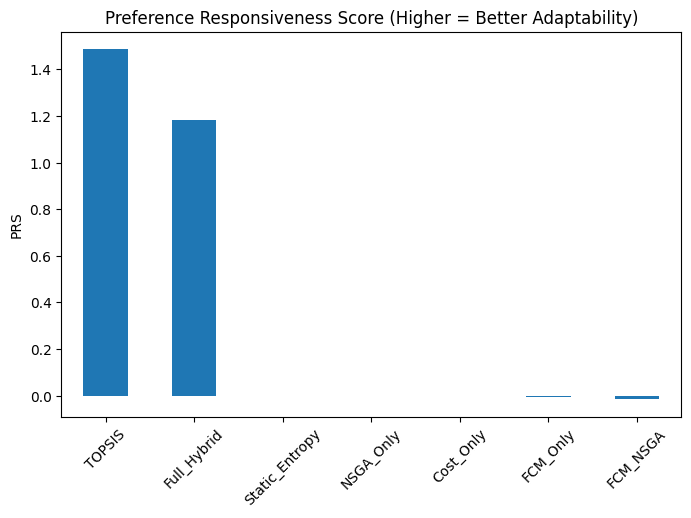

In [84]:
prs_scores.plot(kind="bar", figsize=(8,5))
plt.title("Preference Responsiveness Score (Higher = Better Adaptability)")
plt.ylabel("PRS")
plt.xticks(rotation=45)
plt.show()

In [85]:
elasticity = {}

for model, group in results_df.groupby("Model"):
    slope = np.polyfit(group["Risk_Weight"], group["Emission_Imp"], 1)[0]
    elasticity[model] = slope

pd.Series(elasticity).sort_values(ascending=False)

Full_Hybrid       1.072693e+00
TOPSIS            7.452916e-01
FCM_NSGA          3.683608e-03
NSGA_Only        -1.230695e-16
Cost_Only        -8.398483e-16
Static_Entropy   -8.595431e-16
FCM_Only         -2.375554e-01
dtype: float64

In [86]:
control_span = {}

for model, group in results_df.groupby("Model"):
    span = group["Emission_Imp"].max() - group["Emission_Imp"].min()
    control_span[model] = span

pd.Series(control_span).sort_values(ascending=False)

Full_Hybrid       1.172800
TOPSIS            1.052181
Cost_Only         0.835288
FCM_Only          0.738135
FCM_NSGA          0.720855
NSGA_Only         0.629837
Static_Entropy    0.127927
dtype: float64

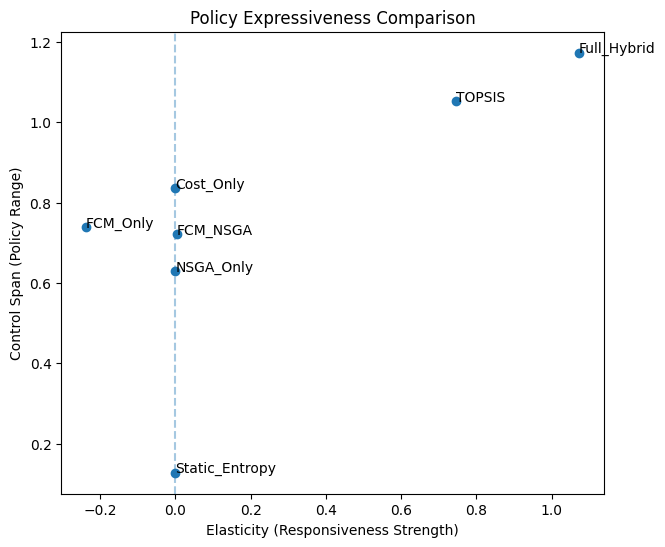

In [87]:
elasticity_series = pd.Series(elasticity)
control_span_series = pd.Series(control_span)

plt.figure(figsize=(7,6))
plt.scatter(elasticity_series, control_span_series)

for model in elasticity_series.index:
    plt.text(elasticity_series[model], control_span_series[model], model)

plt.xlabel("Elasticity (Responsiveness Strength)")
plt.ylabel("Control Span (Policy Range)")
plt.title("Policy Expressiveness Comparison")
plt.axvline(0, linestyle="--", alpha=0.4)
plt.show()

In [88]:
# Balanced performance (equal weight)
results_df["Balanced"] = (
    results_df["Cost_Imp"] +
    results_df["Emission_Imp"] +
    results_df["Deforestation_Imp"]
)

# Aggregate summary
summary = results_df.groupby("Model").agg(
    Mean_Balanced=("Balanced","mean"),
    Std_Balanced=("Balanced","std"),
    Mean_NSG=("NSG","mean")
)

In [90]:
elasticity_series = pd.Series(elasticity)
control_span_series = pd.Series(control_span)

summary["Elasticity"] = elasticity_series
summary["Control_Span"] = control_span_series

In [91]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

norm_df = summary.copy()

scaler = MinMaxScaler()

# Normalize positive metrics
norm_df[["Mean_Balanced","Elasticity","Control_Span"]] = scaler.fit_transform(
    norm_df[["Mean_Balanced","Elasticity","Control_Span"]]
)

# Normalize stability (lower std better)
norm_df["Stability"] = 1 - scaler.fit_transform(
    norm_df[["Std_Balanced"]]
)

# Decision Support Index (equal weighting)
norm_df["DSI"] = (
    norm_df["Mean_Balanced"] +
    norm_df["Elasticity"] +
    norm_df["Control_Span"] +
    norm_df["Stability"]
) / 4

norm_df.sort_values("DSI", ascending=False)

,Mean_Balanced,Std_Balanced,Mean_NSG,Elasticity,Control_Span,Stability,DSI
Model,,,,,,,
TOPSIS,0.825954,0.689969,0.696456,0.750123,0.884561,0.407317,0.716989
Full_Hybrid,0.541708,1.128610,0.317493,1.000000,1.000000,0.000000,0.635427
Static_Entropy,1.000000,0.051707,0.983573,0.181306,0.000000,1.000000,0.545326
FCM_NSGA,0.478977,0.313500,0.349555,0.184117,0.567464,0.756902,0.496865
NSGA_Only,0.497041,0.250693,0.359493,0.181306,0.480355,0.815224,0.493481
Cost_Only,0.523382,0.732045,0.213662,0.181306,0.676983,0.368246,0.437479
FCM_Only,0.000000,0.209500,-0.561471,0.000000,0.584002,0.853475,0.359369


In [93]:
rank_df = summary.copy()

# Rank each metric (higher is better except Std)
rank_df["Rank_Performance"] = rank_df["Mean_Balanced"].rank(ascending=False)
rank_df["Rank_Elasticity"] = rank_df["Elasticity"].rank(ascending=False)
rank_df["Rank_ControlSpan"] = rank_df["Control_Span"].rank(ascending=False)

# Average rank (no weights)
rank_df["Avg_Rank"] = (
    rank_df["Rank_Performance"] +
    rank_df["Rank_Elasticity"] +
    rank_df["Rank_ControlSpan"]
) / 3

rank_df.sort_values("Avg_Rank")

,Mean_Balanced,Std_Balanced,Mean_NSG,Elasticity,Control_Span,Rank_Performance,Rank_Elasticity,Rank_ControlSpan,Avg_Rank
Model,,,,,,,,,
Full_Hybrid,0.686944,1.128610,0.317493,1.072693e+00,1.172800,3.0,1.0,1.0,1.666667
TOPSIS,1.476239,0.689969,0.696456,7.452916e-01,1.052181,2.0,2.0,2.0,2.000000
Cost_Only,0.636056,0.732045,0.213662,-8.398483e-16,0.835288,4.0,5.0,3.0,4.000000
FCM_NSGA,0.512753,0.313500,0.349555,3.683608e-03,0.720855,6.0,3.0,5.0,4.666667
Static_Entropy,1.959527,0.051707,0.983573,-8.595431e-16,0.127927,1.0,6.0,7.0,4.666667
NSGA_Only,0.562915,0.250693,0.359493,-1.230695e-16,0.629837,5.0,4.0,6.0,5.000000
FCM_Only,-0.817268,0.209500,-0.561471,-2.375554e-01,0.738135,7.0,7.0,4.0,6.000000


In [94]:
def pareto_compare(df, target_model):
    target = df.loc[target_model]
    wins = 0

    for model in df.index:
        if model == target_model:
            continue
        
        other = df.loc[model]
        
        better_or_equal = (
            target["Elasticity"] >= other["Elasticity"] and
            target["Control_Span"] >= other["Control_Span"]
        )
        
        strictly_better = (
            target["Elasticity"] > other["Elasticity"] or
            target["Control_Span"] > other["Control_Span"]
        )
        
        if better_or_equal and strictly_better:
            wins += 1
            
    return wins

pareto_compare(summary, "Full_Hybrid")

6

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

adapt_metrics = summary[["Elasticity","Control_Span"]].copy()

target = adapt_metrics.loc["Full_Hybrid"]

dominance_results = []

for model in adapt_metrics.index:
    if model == "Full_Hybrid":
        continue
    
    other = adapt_metrics.loc[model]
    
    better_or_equal = (
        target["Elasticity"] >= other["Elasticity"] and
        target["Control_Span"] >= other["Control_Span"]
    )
    
    strictly_better = (
        target["Elasticity"] > other["Elasticity"] or
        target["Control_Span"] > other["Control_Span"]
    )
    
    dominates = better_or_equal and strictly_better
    
    dominance_results.append({
        "Model": model,
        "Hybrid_Elasticity": target["Elasticity"],
        "Other_Elasticity": other["Elasticity"],
        "Hybrid_ControlSpan": target["Control_Span"],
        "Other_ControlSpan": other["Control_Span"],
        "Dominates": dominates
    })

dominance_df = pd.DataFrame(dominance_results)
dominance_df

,Model,Hybrid_Elasticity,Other_Elasticity,Hybrid_ControlSpan,Other_ControlSpan,Dominates
0,Cost_Only,1.072693,-8.398483e-16,1.1728,0.835288,True
1,FCM_NSGA,1.072693,3.683608e-03,1.1728,0.720855,True
2,FCM_Only,1.072693,-2.375554e-01,1.1728,0.738135,True
3,NSGA_Only,1.072693,-1.230695e-16,1.1728,0.629837,True
4,Static_Entropy,1.072693,-8.595431e-16,1.1728,0.127927,True
5,TOPSIS,1.072693,7.452916e-01,1.1728,1.052181,True


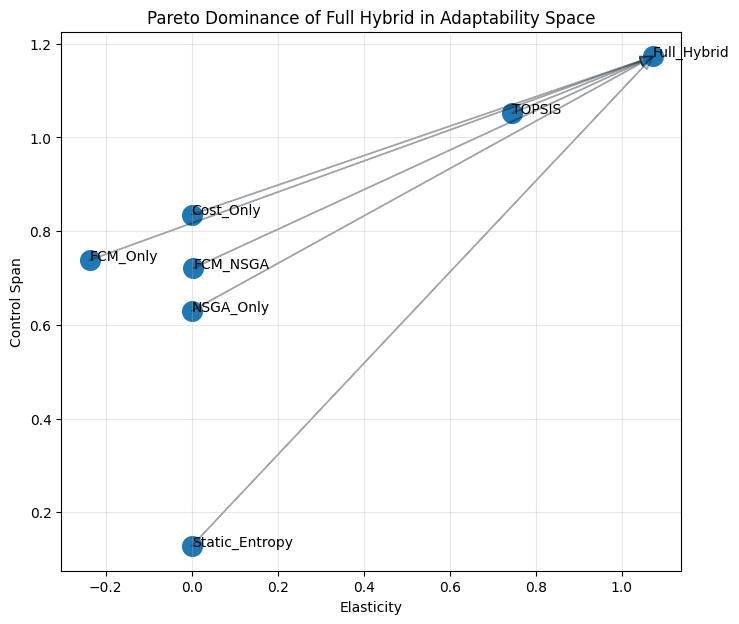

In [96]:
plt.figure(figsize=(8,7))

# Plot all models
plt.scatter(
    adapt_metrics["Elasticity"],
    adapt_metrics["Control_Span"],
    s=200
)

# Label each point
for model in adapt_metrics.index:
    plt.text(
        adapt_metrics.loc[model,"Elasticity"],
        adapt_metrics.loc[model,"Control_Span"],
        model
    )

# Draw arrows from dominated models to Hybrid
for model in adapt_metrics.index:
    if model == "Full_Hybrid":
        continue
        
    plt.arrow(
        adapt_metrics.loc[model,"Elasticity"],
        adapt_metrics.loc[model,"Control_Span"],
        target["Elasticity"] - adapt_metrics.loc[model,"Elasticity"],
        target["Control_Span"] - adapt_metrics.loc[model,"Control_Span"],
        head_width=0.02,
        alpha=0.3,
        length_includes_head=True
    )

plt.xlabel("Elasticity")
plt.ylabel("Control Span")
plt.title("Pareto Dominance of Full Hybrid in Adaptability Space")
plt.grid(alpha=0.3)
plt.show()